In [1]:
import sys
import time
from pathlib import Path
from typing import List, Dict, Any

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt


sys.path.append(str(Path("..").resolve()))
from data_handling import load_measurements_npz, MeasurementDataset, MeasurementLoader
from hyper_rbm import SymmetricHyperRBM, train_loop, get_sigmoid_curve
from wavefunction_overlap import generate_basis_states, calculate_exact_overlap, load_gt_wavefunction


data_dir = Path("measurements")
state_dir = Path("state_vectors")
results_dir = Path("results")
results_dir.mkdir(parents=True, exist_ok=True)

device = "cpu"
print(f"Running on: {device}")

Running on: cpu


In [3]:
def train_experiment_model(file_paths: List[Path], n_samples: int, config: Dict[str, Any],
                           rng: torch.Generator, device: torch.device) -> SymmetricHyperRBM:

    dataset = MeasurementDataset(file_paths, load_measurements_npz, ["h"], [n_samples] * len(file_paths))
    loader = MeasurementLoader(dataset, batch_size=config["batch_size"], shuffle=True, drop_last=False, rng=rng)

    model = SymmetricHyperRBM(num_v=dataset.num_qubits, num_h=config["num_hidden"],
                              hyper_dim=config["hyper_dim"], k=config["k_steps"]).to(device)
    model.initialize_weights(std=config["init_std"])

    optimizer = torch.optim.Adam(model.parameters(), lr=config["init_lr"])

    steps = config["epochs"] * len(loader)
    scheduler = get_sigmoid_curve(config["init_lr"], config["final_lr"], steps, 0.005)

    model = train_loop(model, optimizer,  loader, num_epochs=config["epochs"],
                       lr_schedule_fn=scheduler, noise_frac=config["gibbs_noise"], rng=rng)

    return model


def evaluate_overlap_sweep(model: SymmetricHyperRBM, h_values: List[float],
                           gt_wavefunctions: Dict[float, torch.Tensor], basis_states: torch.Tensor) -> List[float]:
    overlaps = []
    for h in h_values:
        psi_true = gt_wavefunctions[h]
        ov = calculate_exact_overlap(model, h, psi_true, basis_states)
        overlaps.append(ov)

    return overlaps

In [4]:
SIDE_LENGTH = 4
FILE_SAMPLE_COUNT = 20_000

SAMPLE_SIZES = [2_000, 5_000, 20_000]

H_TRAIN = [1.00, 2.00, 3.00, 4.00, 5.00, 6.00, 7.00]
H_EVAL = [1.50, 2.50, 2.80, 3.20, 3.50, 4.50, 5.50]
ALL_H = sorted(list(set(H_TRAIN + H_EVAL)))

SEED = 42
torch.manual_seed(SEED)

file_names = [f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_h{h:.2f}_{FILE_SAMPLE_COUNT}.npz" for h in H_TRAIN]
file_paths = [data_dir / fn for fn in file_names]

print("Pre-loading ground truth wavefunctions...")
all_states = generate_basis_states(SIDE_LENGTH**2, device)
gt_map = {}

for h_val in ALL_H:
    gt_path = state_dir / f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_h{h_val:.2f}.npz"
    gt_map[h_val] = load_gt_wavefunction(gt_path, device)

print(f"Loaded {len(gt_map)} GT states.")

Pre-loading ground truth wavefunctions...
Loaded 14 GT states.


In [5]:
TRAIN_CONFIG = {
    "epochs": 50,
    "batch_size": 1024,
    "num_hidden": 64,
    "hyper_dim": 64,
    "k_steps": 10,
    "init_lr": 1e-2,
    "final_lr": 1e-4,
    "gibbs_noise": 0.1,
    "init_std": 0.05
}

torch.manual_seed(SEED)
rng = torch.Generator().manual_seed(SEED)

results_df = pd.DataFrame({"h": ALL_H})
results_df["type"] = results_df["h"].apply(lambda x: "support" if any(np.isclose(x, s) for s in H_TRAIN) else "novel")

print(f"Starting Experiment Loop: {SAMPLE_SIZES}")

for n_samples in SAMPLE_SIZES:
    print(f"\n### RUNNING: {n_samples} samples per support point ###")

    model = train_experiment_model(file_paths, n_samples, TRAIN_CONFIG, rng, device)
    overlaps = evaluate_overlap_sweep(model, ALL_H, gt_map, all_states)

    col_name = f"overlap_{n_samples}"
    results_df[col_name] = overlaps

    print(f"Finished {col_name}. Mean Overlap: {np.nanmean(overlaps):.5f}")

print("\nAll experiments finished.")

Starting Experiment Loop: [2000, 5000, 20000]

### RUNNING: 2000 samples per support point ###
Epoch  | Loss       | LR        
-----------------------------------
1      | -0.0925     | 0.008451
10     | -0.0160     | 0.007443
20     | +0.0451     | 0.005920
30     | -0.0153     | 0.004204
40     | -0.0124     | 0.002676
50     | -0.0016     | 0.001572
Finished overlap_2000. Mean Overlap: 0.99021

### RUNNING: 5000 samples per support point ###
Epoch  | Loss       | LR        
-----------------------------------
1      | +0.0586     | 0.009854
10     | -0.0039     | 0.009334
20     | -0.0111     | 0.007098
30     | +0.0232     | 0.003023
40     | -0.0253     | 0.000772
50     | -0.0170     | 0.000224
Finished overlap_5000. Mean Overlap: 0.99490

### RUNNING: 20000 samples per support point ###
Epoch  | Loss       | LR        
-----------------------------------
1      | +0.0370     | 0.010000
10     | +0.0128     | 0.010000
20     | +0.0076     | 0.009689
30     | -0.0010     | 0.0004

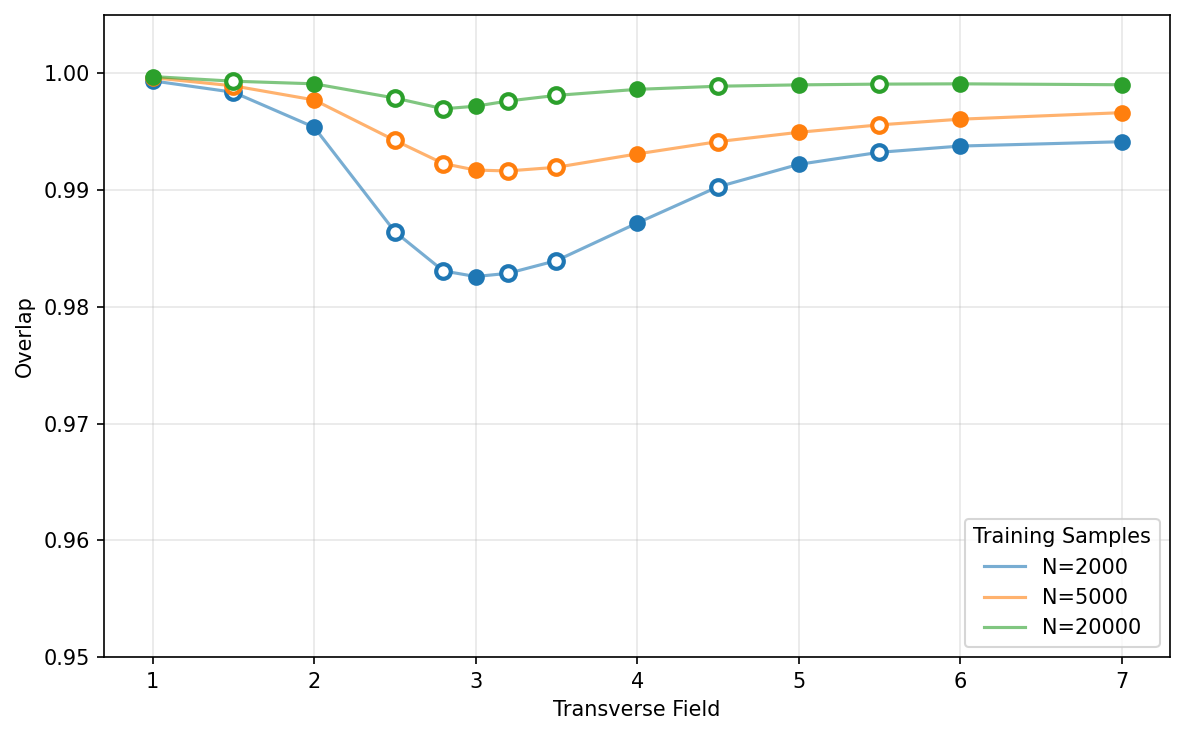

In [6]:
plt.figure(figsize=(8, 5), dpi=150)

support_df = results_df[results_df["type"] == "support"]
novel_df = results_df[results_df["type"] == "novel"]

for i, n_samples in enumerate(SAMPLE_SIZES):
    col = f"overlap_{n_samples}"

    plt.plot(results_df["h"], results_df[col], '-', color=f"C{i}", alpha=0.6, label=f"N={n_samples}")
    plt.plot(support_df["h"], support_df[col], 'o', color=f"C{i}", markersize=7)
    plt.plot(novel_df["h"], novel_df[col], 'o', color=f"C{i}", mfc='white', mew=2, markersize=7)

plt.xlabel("Transverse Field")
plt.ylabel("Overlap")
plt.ylim(0.95, 1.005)
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right', title="Training Samples")
plt.tight_layout()
plt.show()

In [7]:
timestamp = time.strftime("%Y%m%d_%H%M%S")
filename = f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_sample_eff_rbm_{timestamp}.csv"
save_path = results_dir / filename

results_df.to_csv(save_path, index=False, float_format="%.6f")
print(f"Experiment results saved to: {save_path}")

Experiment results saved to: results/tfim_4x4_sample_eff_rbm_20260119_192457.csv
